In [1]:
import numpy  as np
import pandas as pd
import data_tools
import itertools
import matplotlib.pyplot as plt
import concurrent
import multiprocessing as mp

from matplotlib import cm
from scipy.stats import norm
from Models.models import *
from time import time
from quadtree import Point, Rect, QuadTree

## Some functions 

In [576]:
coefs_log_prices = loadtxt('Models/coeficients/log_prices.csv')
coefs_mean_rever = loadtxt('Models/coeficients/mean_rever.csv')

def model_log_prices(t,prev,prev_x,prev_y_x):
    f = lambda x: coefs_log_prices[0] + coefs_log_prices[1] * sin((coefs_log_prices[2]+x)*2*pi/12)
    X = lambda x,x_y: coefs_mean_rever[0]*x + coefs_mean_rever[1] * x_y
    return log(prev) + f(t) + X(prev_x,prev_y_x)

def mean_rever(prev_x,prev_y_x):
    return coefs_mean_rever[0] * prev_x + coefs_mean_rever[1] * prev_y_x

def residual(prev_price, curr_price,t):
    f = lambda x: coefs_log_prices[0] + coefs_log_prices[1] * sin((coefs_log_prices[2]+x)*2*pi/12)
    return log(curr_price) - log(prev_price) - f(t)

def residual_with_X(prev_price,curr_price,X,t):
    f = lambda x: coefs_log_prices[0] + coefs_log_prices[1] * sin((coefs_log_prices[2]+x)*2*pi/12)
    return log(curr_price) - log(prev_price) - f(t) - X



In [6]:
ts = pd.read_csv('Preprocessed_data/ts.csv')

log_diff_prices = ts.price.values
log_diff_prices = np.array(log_diff_prices, dtype=float)
log_diff_prices = np.diff(np.log(log_diff_prices))
log_diff_prices = np.concatenate((np.array([0]), log_diff_prices))
ts['log_diff_prices'] = log_diff_prices

yearmonth = list(ts['yearmonth'])
x_label   = data_tools.from_index_to_dates(yearmonth)

ts['X']                = np.zeros(ts.shape[0])
ts['price_residual']   = np.zeros(ts.shape[0])
ts['storage_residual'] = np.zeros(ts.shape[0])

for t in ts.index:
    if t == 0:
        continue
    #storage residuals
    
    pred_storage = model_storage(model_inflow, ts.loc[t-1,'inflow'] , model_evaporation, t, ts.loc[t-1,'storage'], ts.loc[t,'outflow'])
    
    ts.loc[t,'storage_residual'] = ts.loc[t,'storage'] - pred_storage
    
    #prices residuals
        
    curr_price = ts.loc[t  , 'price']
    prev_price = ts.loc[t-1, 'price']
    
    if t < 12:
        ts.loc[t,'X'] = residual(prev_price,curr_price,t)
        ts.loc[t,'price_residual'] = 0
        continue
     
    
    prev_x   = ts.loc[t-1 ,'X']
    prev_y_x = ts.loc[t-12,'X']
    
    ts.loc[t,'X'] = residual(prev_price, curr_price, t)
    
    expected_X = mean_rever(prev_x,prev_y_x)
    
    ts.loc[t,'price_residual'] = residual_with_X(prev_price,curr_price,expected_X,t)
    

# correlation between residuals:

storage_res = ts['storage_residual'].values
prices_res  = ts['price_residual'  ].values

correlation = np.corrcoef(ts['storage_residual'].values[12:], ts['price_residual'].values[12:])[0,1]

eta = 0.5
zd  = 105.69451612903225
r   = 0.0041

discount = 1/(1+r)

elev_stor = zip(ts.elevation.values,ts.storage.values)
elev_stor = sorted(elev_stor, key=lambda x: (x[1],x[0]))

def get_middle_points(x):
    x = np.array(x)
    return (x[:-1] + x[1:])/2


def pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation):
    
    expected_storage = model_storage(model_inflow, inflow , model_evaporation, t, storage, q) # this may not be needed if forecast is done.
    return eta * q * ((z(storage, elev_stor) + z(expected_storage,elev_stor))/2 - zd) * P





## Define inputs

### Grids

In [9]:
N = 60 # For the storage grid
M = 100 # For the price grid
L = 30 # For the outflow grid
S = 30 # For the states

discount = 1/(1+r)

#P_min = 0.020
P_min = 0
P_max = 0.35

I_min = 1750
I_max = 3250
boundaries = [2000,3000]

q_min = 0
q_max = 245

price_grid   = get_middle_points(np.arange(P_min, P_max+ 2**-15, (P_max - P_min)/M))
storage_grid = get_middle_points(np.arange(I_min, I_max+ 2**-15, (I_max - I_min)/N))


rho = 2.33
K = 10 # number of shocks in the storage grid
J = 10 # number of shocks in the prices grid

shocks_storage  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ K))

dist_shocks_storage = (shocks_storage[1] - shocks_storage[0])/2
prob_shocks_storage = norm.cdf(shocks_storage[:] + dist_shocks_storage) - norm.cdf(shocks_storage[:] - dist_shocks_storage)

shocks_prices  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ J))

dist_shocks_prices = (shocks_prices[1] - shocks_prices[0])/2
prob_shocks_prices = norm.cdf(shocks_prices[:] + dist_shocks_prices) - norm.cdf(shocks_prices[:] - dist_shocks_prices)



outflow_grid = np.arange(q_min, q_max+ 2**-15, (q_max - q_min)/L) # L+1 elements

V0 = np.zeros((S+1,N,M))
V1 = np.zeros((S+1,N,M))

policy = np.zeros((S,N,M))

step_price   = price_grid[1]   - price_grid[0]
step_storage = storage_grid[1] - storage_grid[0]

coord = lambda x,y: (int((x - storage_grid[0])/step_storage) * step_storage + storage_grid[0], int((y - price_grid[0])/step_price) * step_price + price_grid[0])

coord_array = lambda x,y: (((x - storage_grid[0])/step_storage + 0.5).astype(int), ((y - price_grid[0])/step_price + 0.5).astype(int))

coord_array_exact = lambda x,y: ((x - storage_grid[0])/step_storage, (y - price_grid[0])/step_price)

coord_array_upper = lambda x,y,x_cond,y_cond: (((x - storage_grid[0])/step_storage + 1*(~x_cond)).astype(int), ((y - price_grid[0])/step_price + 1*(~y_cond)).astype(int))
coord_array_lower = lambda x,y: (((x - storage_grid[0])/step_storage).astype(int), ((y - price_grid[0])/step_price ).astype(int))

### Forecast inflow and storage

In [10]:
time_0 = ts.shape[0]
ts_forecast = ts.copy()

for i in range(S):
    
    current_time = time_0 + i
    
    prev_inflow  = ts_forecast.loc[current_time - 1, 'inflow' ]
    prev_storage = ts_forecast.loc[current_time - 1, 'storage']
    
    current_storage = model_storage(model_inflow,prev_inflow, model_evaporation, current_time, prev_storage, prev_inflow)
    current_inflow  = model_inflow(current_time, prev_inflow)
    
    ts_forecast.loc[current_time,'storage'] = current_storage
    ts_forecast.loc[current_time,'inflow']  = current_inflow

### Forecast prices

In [11]:
# Forecasting Prices M steps ahead
for i in range(S):
    
    current_time = time_0 + i
    
    prev     = ts_forecast.loc[current_time-1,  'price']
    prev_x   = ts_forecast.loc[current_time-1,  'X']
    prev_y_x = ts_forecast.loc[current_time-12, 'X']
    
    log_P      = model_log_prices(current_time,prev, prev_x, prev_y_x)
    curr_price = np.exp(log_P)
    
    ts_forecast.loc[current_time,'price'] = curr_price
    
    X = residual(prev,curr_price,current_time)
    ts_forecast.loc[current_time,'X'] = X

In [12]:
ts_forecast

,yearmonth,price,storage,inflow,outflow,elevation,evaporation,log_diff_prices,X,price_residual,storage_residual
0,200401.0,0.090000,2423.144516,64.557774,38.687065,174.703871,2.294,0.000000,0.000000e+00,0.0,0.000000
1,200402.0,0.090000,2556.166034,96.107276,46.154448,175.564310,2.945,0.000000,-1.104011e-02,0.0,21.973002
2,200403.0,0.090000,2588.537645,79.366548,52.743226,175.769871,4.587,0.000000,-1.814998e-02,0.0,-1.862477
3,200404.0,0.091000,2638.082300,78.393133,37.528267,176.078700,5.578,0.011050,-9.974713e-03,0.0,-75.529809
4,200405.0,0.094000,2668.301839,46.613065,58.082258,176.266323,6.569,0.032435,1.354170e-02,0.0,-49.518646
...,...,...,...,...,...,...,...,...,...,...,...
217,NaN,0.152127,2505.574762,90.799522,NaN,NaN,NaN,NaN,-8.326673e-17,NaN,NaN
218,NaN,0.154913,2438.244680,66.437722,NaN,NaN,NaN,NaN,9.020562e-17,NaN,NaN
219,NaN,0.158205,2481.267710,85.198491,NaN,NaN,NaN,NaN,8.673617e-17,NaN,NaN
220,NaN,0.161222,2494.467394,92.934748,NaN,NaN,NaN,NaN,-9.367507e-17,NaN,NaN


## Algorithm 

In [26]:
pi_call = lambda storage, inflow, t, P, q: pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation)

In [27]:
def pi_call_0(storage, inflow, t, P, q):
    if storage > 2e4 or storage < 3e4:
        return pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation) 
    else:
        return -1e7
    
    
coefs_log_prices = loadtxt('Models/coeficients/log_prices.csv')
seasonality = lambda x: coefs_log_prices[0] + coefs_log_prices[1] * sin((coefs_log_prices[2]+x)*2*pi/12)
mean_rever  = lambda x: -0.4 * x 

def next_price_revert(t,prev, reversion, shock_m):
    f = lambda x: coefs_log_prices[0] + coefs_log_prices[1] * sin((coefs_log_prices[2]+x)*2*pi/12)
    return prev*exp(f(t) + mean_rever(reversion) + prices_sd * shock_m)



In [28]:
                          
def prepro_coord_array(x,y):
    
    cond_storage = np.logical_or(x<storage_grid[0], x>storage_grid[-1])
    x[x<storage_grid[0]]  = storage_grid[0]
    x[x>storage_grid[-1]] = storage_grid[-1]
    
    y[y<price_grid[0] ] = price_grid[0]
    y[y>price_grid[-1]] = price_grid[-1]
    cond_price = np.logical_or(x<price_grid[0], x>price_grid[-1])

    return x,y, cond_storage, cond_price

def future_payments(V,A,shocks_storage, shocks_price, input_next_storage, input_next_price, price_grid, storage_grid,boundaries,ts_forecast):
    K = len(shocks_storage)
    J = len(shocks_price  )
    
    future_payment = np.zeros((K,J))
        
    future_storage = next_storage(*input_next_storage, shocks_storage)
    cond = np.logical_or(future_storage < boundaries[0], future_storage > boundaries[1])
    reversion = np.log(input_next_price[1]) - np.log(ts_forecast.loc[input_next_price[0] - 1, 'price']) - seasonality(input_next_price[0]) 
#     future_price = next_price_revert(  *input_next_price, reversion  , shocks_price)
    future_price = next_price(  *input_next_price  , shocks_price)
    cond = np.meshgrid(cond,future_price)[0]
    
    under_storage = False
    over_storage  = False
    
    if future_storage.min() < boundaries[0]:
        # return 0, True, False
        under_storage = True
        over_storage  = False
    elif future_storage.max() > boundaries[1]:
        # return 0, False, True
        
        under_storage = False
        over_storage  = True
    
    
    future_storage, future_price, cond_storage, cond_price = prepro_coord_array(future_storage, future_price)
    future_storage_upper, future_price_upper = coord_array_upper(future_storage, future_price,cond_storage, cond_price) # at this point future_price is the coord in V
    future_storage_lower, future_price_lower = coord_array_lower(future_storage, future_price)
    future_storage_closest, future_price_closest = coord_array(future_storage, future_price) # at this point future_price is the coord in V
    
    future_storage_upper[cond_storage] = future_storage_closest[cond_storage]
    future_price_upper[cond_price] = future_price_closest[cond_price]
    future_storage_exact, future_price_exact = coord_array_exact(future_storage, future_price)
    
    weight_storage = np.ones(K) - future_storage_exact + future_storage_lower
    weight_price   = np.ones(J) - future_price_exact   + future_price_lower
    
    W_storage = np.outer(weight_storage, np.ones(K))
    W_price   = np.outer(weight_price,   np.ones(J))
    W = (W_storage + W_price)/2
    
    future_storage_lower_cd ,future_price_lower_cd = np.meshgrid(future_storage_lower, future_price_lower)
    future_storage_upper_cd ,future_price_upper_cd = np.meshgrid(future_storage_upper, future_price_upper)

    future_value = W * V[future_storage_lower_cd, future_price_lower_cd] + (-W + 1) * V[future_storage_upper_cd, future_price_upper_cd]
    
    #future_storage ,future_price = np.meshgrid(future_storage, future_price)

    future_payment = np.multiply(future_value, A)
    
    # return np.sum(future_payment[~cond]), False, False
    return np.sum(future_payment[~cond]), under_storage, over_storage

In [29]:
def action_value(input_next_storage, input_next_price, V0, A, shocks_storage, shocks_prices, price_grid, storage_grid, boundaries, ts_forecast):

    # s_next = s+1 % 12 # The value grid is ciclic
    s_next = (s+1)
    next_state_value, under_storage, over_storage = future_payments(V0[s_next],A, shocks_storage, shocks_prices,
                                                            input_next_storage, input_next_price, 
                                                            price_grid, storage_grid, boundaries, ts_forecast)
    q = input_next_storage[-2]
    
#     print(next_state_value)
    
    if under_storage: 
#         return - q # the lower the water usage the better when under storage
        return 0 + discount * next_state_value
    elif over_storage:
#         if q == 0:
#             q = 2**-8
#        return - 1/q # the more water usage the better when over storage
        return 0 + discount * next_state_value
                       # in both cases the value is negativo to discourage this kind of state
    else:
#         print(f'total = {pi_call_0(storage, inflow, current_time, price, q) + discount * next_state_value}')
#         print(f'pi = {pi_call_0(storage, inflow, current_time, price, q)}')
#         print(f'V+1 = { discount * next_state_value}' )
        return pi_call_0(storage, inflow, current_time, price, q) + discount * next_state_value

In [30]:
def future_payments_print(V,A,shocks_storage, shocks_price, input_next_storage, input_next_price, price_grid, storage_grid,boundaries, ts_forecast):
    K = len(shocks_storage)
    J = len(shocks_price  )
    
    future_payment = np.zeros((K,J))
        
    future_storage = next_storage(*input_next_storage, shocks_storage)
    print(future_storage)
    cond = np.logical_or(future_storage < boundaries[0], future_storage > boundaries[1])
    reversion = np.log(input_next_price[1]) - np.log(ts_forecast.loc[input_next_price[0] - 1, 'price']) - seasonality(input_next_price[0]) 
    print(reversion)
    future_price = next_price_revert(  *input_next_price, reversion  , shocks_price)
    print(future_price)
    cond = np.meshgrid(cond,future_price)[0]
    
    if future_storage.min() < boundaries[0]:
        return 0, True, False
    elif future_storage.max() > boundaries[1]:
        return 0, False, True

    future_storage, future_price, cond_storage, cond_price = prepro_coord_array(future_storage, future_price)
    future_storage_upper, future_price_upper = coord_array_upper(future_storage, future_price,cond_storage, cond_price) # at this point future_price is the coord in V
    future_storage_lower, future_price_lower = coord_array_lower(future_storage, future_price)
    future_storage_closest, future_price_closest = coord_array(future_storage, future_price) # at this point future_price is the coord in V
    
    future_storage_upper[cond_storage] = future_storage_closest[cond_storage]
    future_price_upper[cond_price] = future_price_closest[cond_price]
    future_storage_exact, future_price_exact = coord_array_exact(future_storage, future_price)
    
    print(future_storage)
    print(future_storage_exact)
    print(future_storage_lower)
    print(future_storage_upper)
    
    
    weight_storage = np.ones(K) - future_storage_exact + future_storage_lower
    weight_price   = np.ones(J) - future_price_exact   + future_price_lower
    
    W_storage = np.outer(weight_storage, np.ones(K))
    W_price   = np.outer(weight_price,   np.ones(J))
    W = (W_storage + W_price)/2
    
    future_storage_lower_cd ,future_price_lower_cd = np.meshgrid(future_storage_lower, future_price_lower)
    future_storage_upper_cd ,future_price_upper_cd = np.meshgrid(future_storage_upper, future_price_upper)
    print(future_storage_lower_cd)
    future_value = W * V[future_storage_lower_cd, future_price_lower_cd] + (-W + 1) * V[future_storage_upper_cd, future_price_upper_cd]
    
    #future_storage ,future_price = np.meshgrid(future_storage, future_price)

    future_payment = np.multiply(future_value, A)

    return np.sum(future_payment[~cond]), False, False

def action_value_print(input_next_storage, input_next_price, V0, A, shocks_storage, shocks_prices, price_grid, storage_grid, boundaries, ts_forecast):

    # s_next = s+1 % 12 # The value grid is ciclic
    s_next = (s+1)
    print(input_next_storage[-2])
    next_state_value, under_storage, over_storage = future_payments_print(V0[s_next],A, shocks_storage, shocks_prices,
                                                            input_next_storage, input_next_price, 
                                                            price_grid, storage_grid, boundaries, ts_forecast)
    q = input_next_storage[-2]
    
    
    if under_storage: 
        return - q # the lower the water usage the better when under storage
    elif over_storage:
        if q == 0:
            q = 2**-8
        return - 1/q # the more water usage the better when over storage
                       # in both cases the value is negativo to discourage this kind of state
    else:
        print(f'total = {pi_call_0(input_next_storage[4], inflow, current_time, input_next_price[1], input_next_storage[-2]) + discount * next_state_value}')
        print(f'pi = {pi_call_0(input_next_storage[4], inflow, current_time, input_next_price[1], input_next_storage[-2])}')
        print(f'V+1 = { discount * next_state_value}' )
        return pi_call_0(input_next_storage[4], inflow, current_time, input_next_price[1], input_next_storage[-2]) + discount * next_state_value

In [92]:
max_ite = 25
ite     = 0
tol     = 2**-15

A = np.outer(prob_shocks_storage,prob_shocks_prices)


t0 = time()
while ite < max_ite:
    
    for s in range(S):
        current_time = time_0 + s
        inflow       = ts_forecast.loc[current_time,'inflow']
        
        for n in range(N):
            storage      = storage_grid[n]
            
            for m in range(M):
                price = price_grid[m]
                rewards = []
                
                input_next_storage = [model_inflow, inflow , model_evaporation, current_time,
                          storage, 0, model_storage]
                
                input_next_price   = [current_time, price]
                
                for q in outflow_grid:
                    
                    input_next_storage[-2] = q
                    
                    rewards.append(action_value(input_next_storage, input_next_price, V0, A, shocks_storage, shocks_prices, price_grid, storage_grid, boundaries, ts_forecast))
#                     if n == 10 and m == 75 and s == 5:
#                         print(action_value_print(input_next_storage, input_next_price, V0, A, shocks_storage, shocks_prices, price_grid, storage_grid, boundaries, ts_forecast))
#                         print(input_next_storage)
#                         print(input_next_price)
#                 if n == 10 and m == 75 and s == 5:
#                     print(rewards)
                    
                policy[s,n,m] = outflow_grid[np.argmax(rewards)]
                V1[s,n,m]     = np.max(rewards) 
#                 policy[s%12 ,n,m] = outflow_grid[np.argmax(rewards)]
#                 V1[s%12 ,n,m]     = np.max(rewards) 

    error = np.max(np.abs(V0-V1))/np.max(V1)
    if error < tol:
        V0 = V1.copy()
        print(time()-t0)
        print(f'Iteration: {ite}')
        print(f'Error is: {error}')
        break
        
    V0   = V1.copy()
    ite += 1
    print(time()-t0)
    print(f'Iteration: {ite}')
    print(f'Error is: {error}')
    print('='*50)

1241.6319270133972
Iteration: 1
Error is: 0.10685434787834742
2509.352931022644
Iteration: 2
Error is: 0.09237165297158026
3780.229454755783
Iteration: 3
Error is: 0.08219013521306992
5027.422900438309
Iteration: 4
Error is: 0.07536436165705108
6272.542523384094
Iteration: 5
Error is: 0.06972160264904831
7550.595586299896
Iteration: 6
Error is: 0.06454057854448202
8840.124428510666
Iteration: 7
Error is: 0.05964633395643926
10127.019263744354
Iteration: 8
Error is: 0.05512368547935249
11397.025302410126
Iteration: 9
Error is: 0.050917998291551615
12661.935456514359
Iteration: 10
Error is: 0.04663579965499879
13915.244279623032
Iteration: 11
Error is: 0.04340254625358482
15161.795085906982
Iteration: 12
Error is: 0.04016991037098533
16413.74834370613
Iteration: 13
Error is: 0.03710041207262385
17675.08016347885
Iteration: 14
Error is: 0.03440098637169552
18940.40891957283
Iteration: 15
Error is: 0.028811118833476784
20204.759380817413
Iteration: 16
Error is: 0.026995373081795233
21464.2

In [737]:
#Saves and loads policy in the mean reverting directory

policy.tofile('Results/mr_model.txt')
#V0.tofile('Results/mr_values.txt')
yes_mr = open("Results/mr_model.txt")

original = np.fromfile(yes_mr)
original = original.reshape((S,N,M))

In [96]:
#Saves and loads policy in the non-mean reverting directory

#policy.tofile('Results/non_mr_model.txt')
no_mr    = open("Results/non_mr_model.txt")

original = np.fromfile(no_mr)
original = original.reshape((S,N,M))
no_mr.close()

#V0.tofile('Results/V0_non_mr_model.txt')
V0_no_mr = open("Results/V0_non_mr_model.txt")
original_V0 = np.fromfile(V0_no_mr)
original_V0 = original_V0.reshape((S+1,N,M))

In [68]:
def plot_policy(storage_grid, price_grid, policy):
    x,y = np.meshgrid(storage_grid, price_grid)
    policy = np.transpose(policy)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(x,y,policy, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(30, 230)
    ax.set_xlabel('storage (MCM)')
    ax.set_ylabel('price ($/kwh)')
    ax.set_zlabel('outflow (m^3/s)')
#     ax.set_title('Optimal policy (outflow) for different prices \n and storages at a given time (03/2020)')
#     ax.set_title('Optimal policy (outflow) for different prices \n and storages at a given time (06/2020)')
#     ax.set_title('Optimal policy (outflow) for different prices \n and storages at a given time (09/2020)')
#     plt.savefig('Figures/3d_03_non_mr.pdf', format='pdf')
#     plt.savefig('Figures/3d_06_non_mr.pdf', format='pdf')
#     plt.savefig('Figures/3d_09_non_mr.pdf', format='pdf')
    plt.show()
    
def plot_value(storage_grid, price_grid, value):
    x,y = np.meshgrid(storage_grid, price_grid)
    value = np.transpose(value)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(x,y,value, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(30, 230)
    ax.set_xlabel('storage (MCM)')
    ax.set_ylabel('price ($/kwh)')
    ax.set_zlabel('Value')
    plt.show()

<ipython-input-68-35d55cf16015>:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


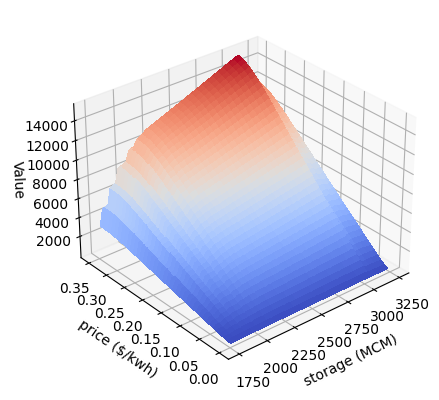

In [95]:
plot_value(storage_grid, price_grid, V0[0])

<ipython-input-68-35d55cf16015>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


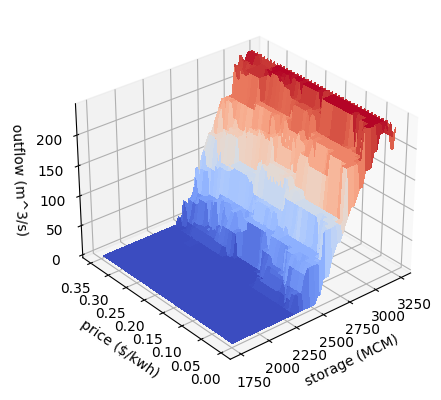

In [134]:
plot_policy(storage_grid,price_grid,policy[10])

<ipython-input-68-35d55cf16015>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


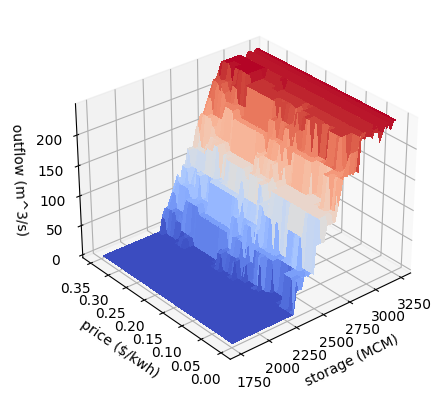

0.14222738631468992


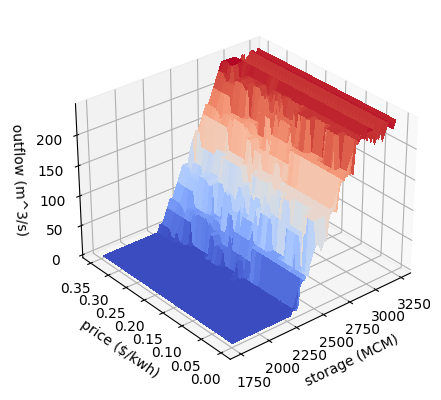

0.14380629259757194


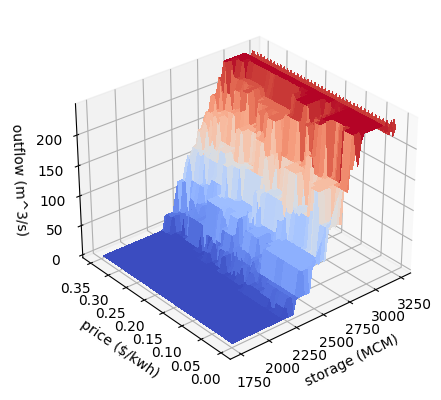

0.14644020458684237


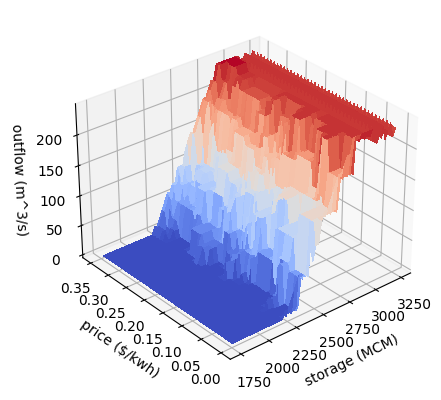

0.1495516374453799


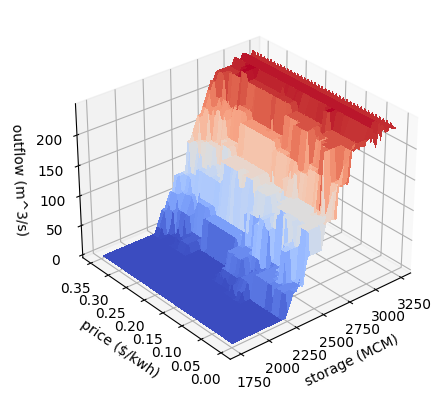

0.15240406446790988


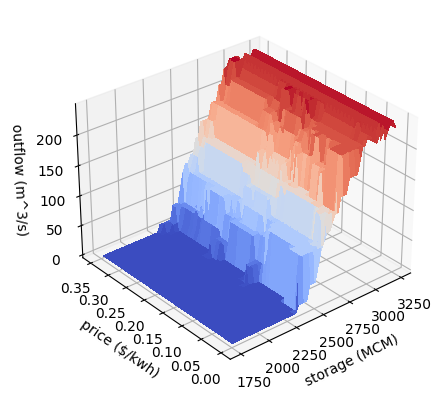

0.15429454027491923


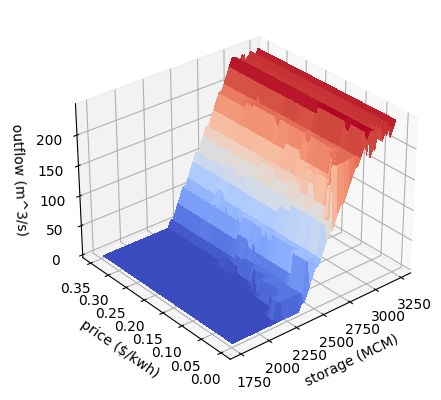

0.1547716182876095


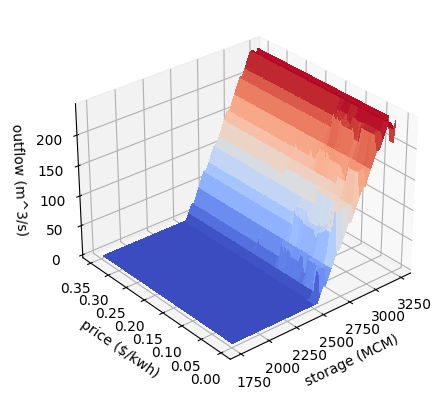

0.15379149271175913


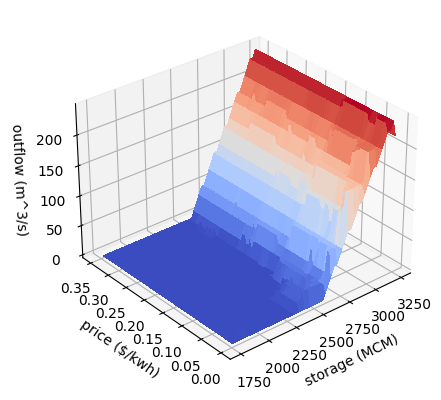

0.15173491473529746


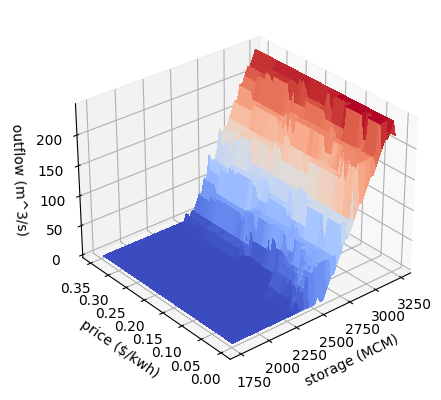

0.1492761167956139


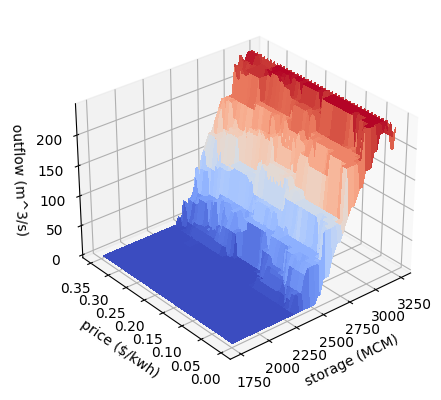

0.147170444543283


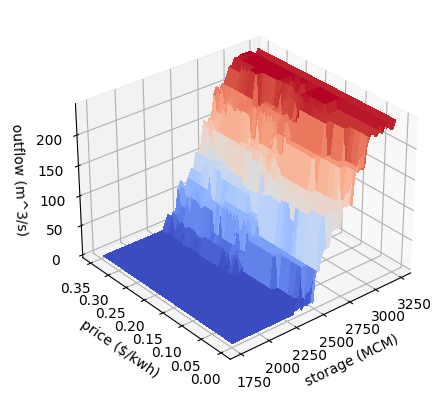

0.14605022886789407


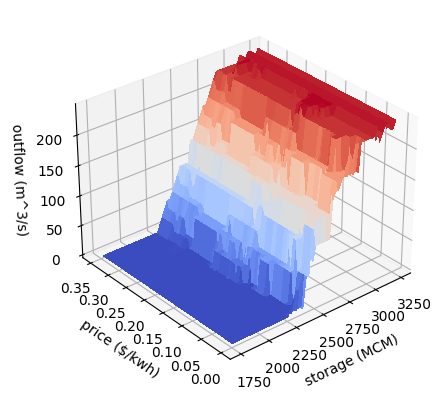

0.1462841008629778


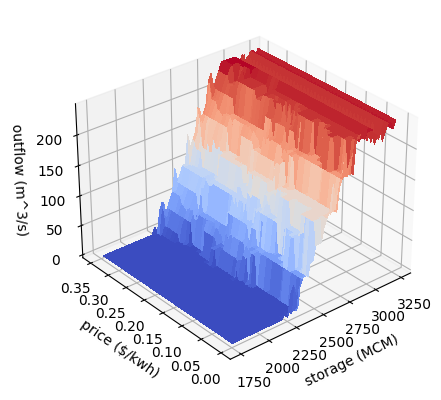

0.14790804187689244


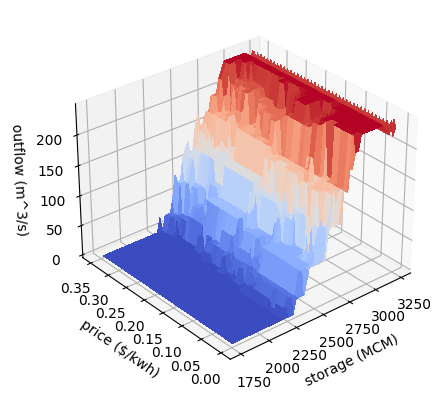

0.1506170802490814


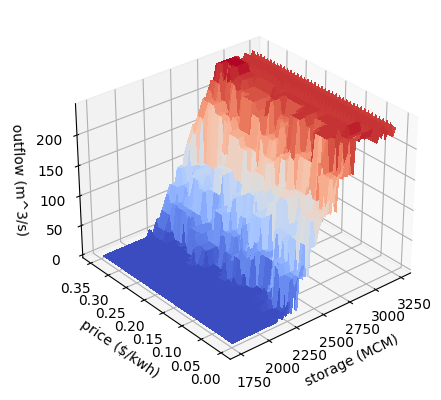

0.1538172596934229


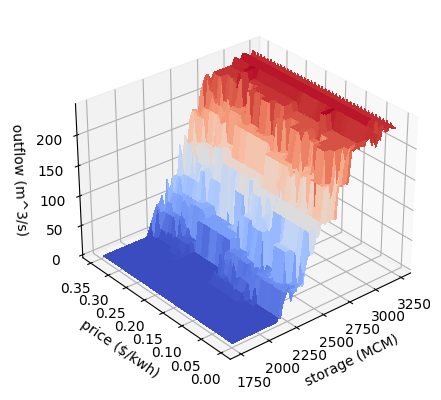

0.1567510457460248


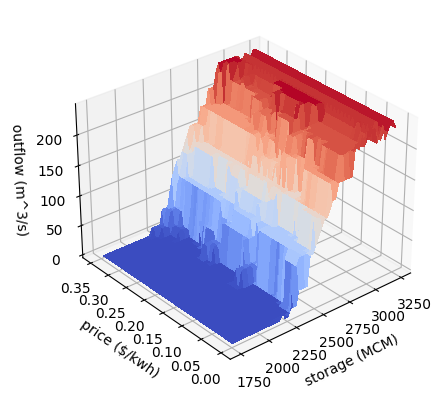

0.15869544310012998


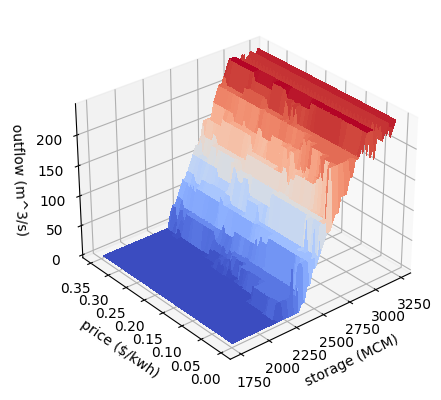

0.15918612868422324


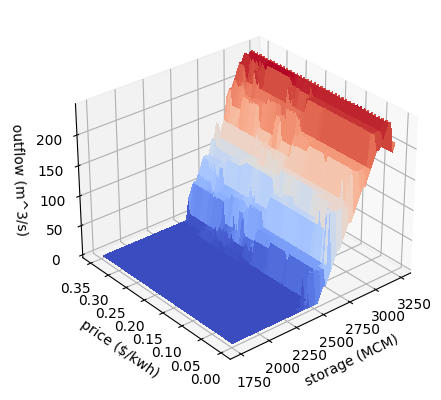

0.15817804724286957


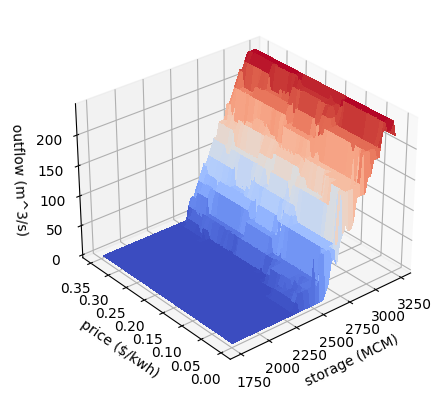

0.1560628100305675


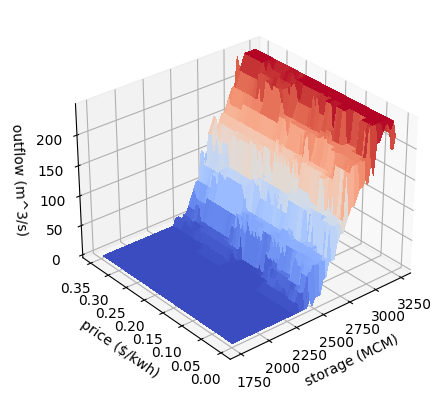

0.15353388044021052


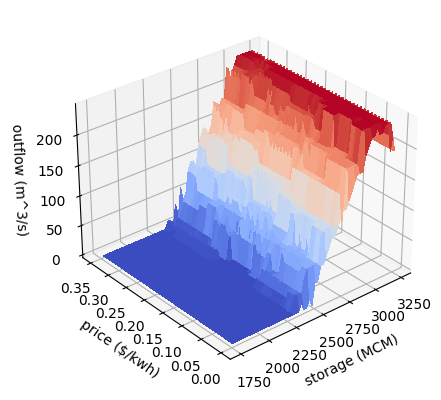

0.1513681486488464


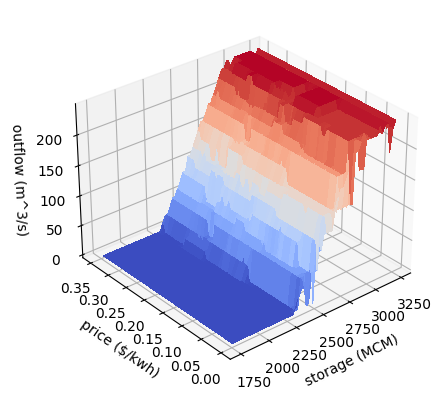

0.15021598135467767


In [94]:
for s in range(24):
    plot_policy(storage_grid,price_grid,policy[s])
    print(ts_forecast.loc[time_0+s, 'price'])

In [443]:
np.sum(shocks_prices[:-1] - shocks_prices[1:])

-4.194

In [724]:
ts_forecast

,yearmonth,price,storage,inflow,outflow,elevation,evaporation,log_diff_prices,X,price_residual,storage_residual
0,197811.0,0.032,2395.579933,58.861267,12.551833,174.519400,2.956133,0.000000,0.000000,0.0,0.000000
1,197812.0,0.034,2565.273452,83.033097,31.811645,175.622903,2.294000,0.060625,0.084194,0.0,23.956393
2,197901.0,0.035,2631.896774,81.032710,59.487194,176.041710,2.378000,0.028988,0.031854,0.0,55.258258
3,197902.0,0.034,2616.399964,120.969464,74.827143,175.944821,3.179571,-0.028988,-0.048371,0.0,-47.295466
4,197903.0,0.036,2699.456935,173.260355,156.973677,176.454548,4.714871,0.057158,0.019941,0.0,233.709040
...,...,...,...,...,...,...,...,...,...,...,...
519,NaN,NaN,2490.805076,85.198491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,NaN,NaN,2506.500139,92.934748,NaN,NaN,NaN,NaN,NaN,NaN,NaN
521,NaN,NaN,2487.370727,87.775657,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,NaN,NaN,2508.376198,98.558427,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<ipython-input-68-35d55cf16015>:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


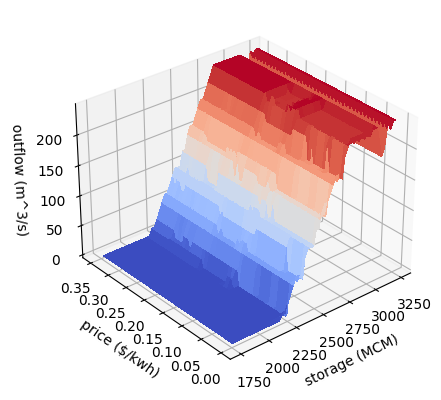

0.14222738631468992


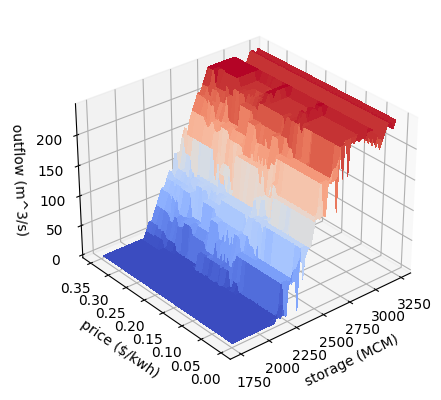

0.14380629259757194


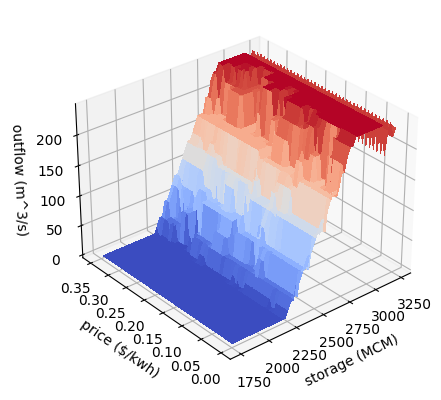

0.14644020458684237


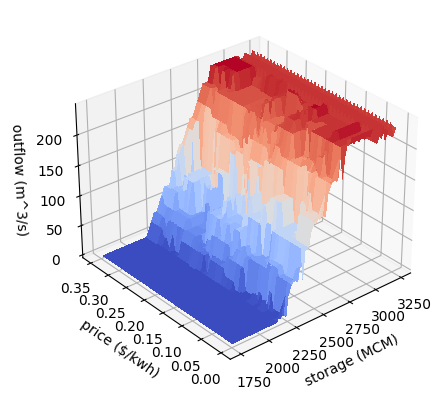

0.1495516374453799


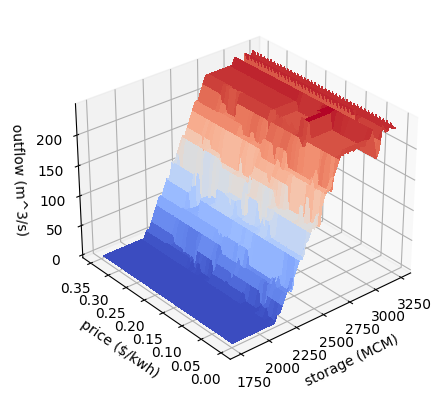

0.15240406446790988


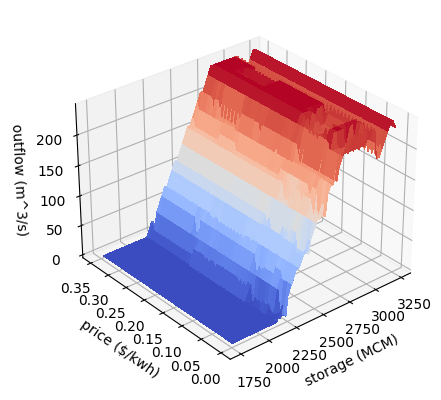

0.15429454027491923


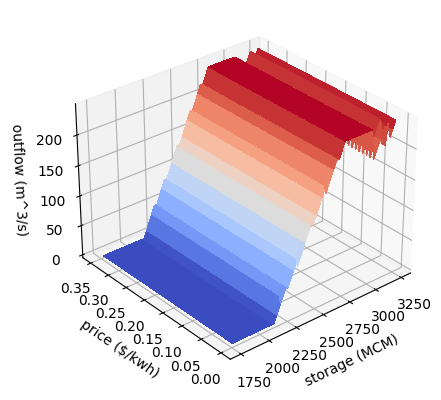

0.1547716182876095


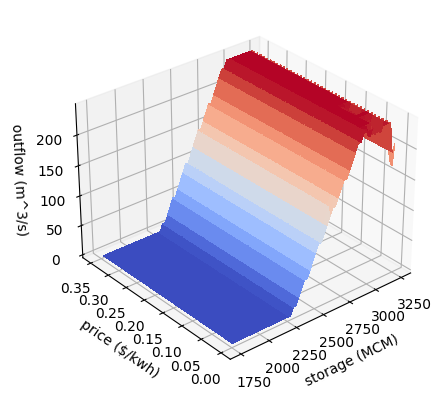

0.15379149271175913


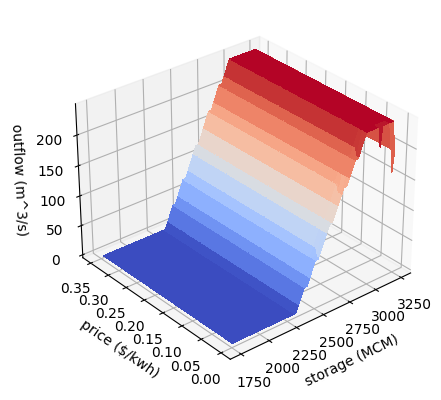

0.15173491473529746


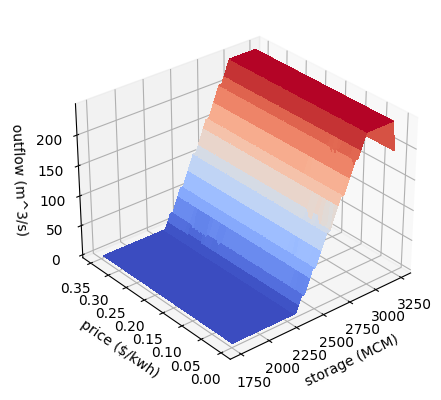

0.1492761167956139


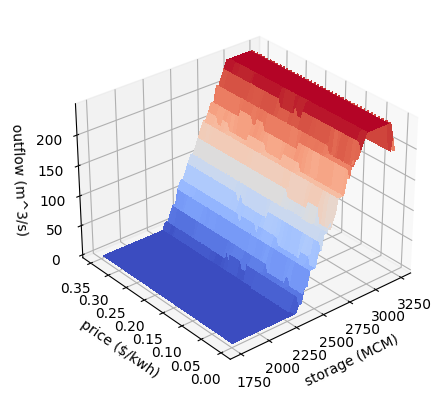

0.147170444543283


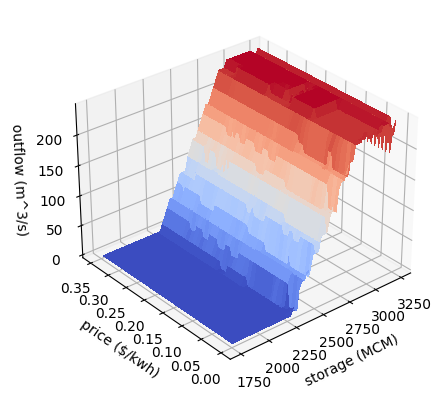

0.14605022886789407


In [91]:
for s in range(12):
    plot_policy(storage_grid,price_grid,policy[s])
    print(ts_forecast.loc[time_0+s, 'price'])

### Working with the policy towards an optimal solution

In [ ]:
print(price_grid)
print(storage_grid)

[0.02575 0.03725 0.04875 0.06025 0.07175 0.08325 0.09475 0.10625 0.11775
 0.12925 0.14075 0.15225 0.16375 0.17525 0.18675 0.19825 0.20975 0.22125
 0.23275 0.24425]
[1765. 1795. 1825. 1855. 1885. 1915. 1945. 1975. 2005. 2035. 2065. 2095.
 2125. 2155. 2185. 2215. 2245. 2275. 2305. 2335. 2365. 2395. 2425. 2455.
 2485. 2515. 2545. 2575. 2605. 2635. 2665. 2695. 2725. 2755. 2785. 2815.
 2845. 2875. 2905. 2935. 2965. 2995. 3025. 3055. 3085. 3115. 3145. 3175.
 3205. 3235.]


In [140]:
print(input_storage)
print(storage_coor)
print(input_price)
print(price_coor)

2507.876580645161
5
0.142
8


In [240]:
ts.loc[time_0-1,'outflow']

1.4231612903225803

In [278]:
def closest_argument(value, array):
    return np.argmin(np.abs(array-value))

In [310]:
ts

,yearmonth,price,storage,inflow,outflow,elevation,evaporation,log_diff_prices,X
0,197811,0.032,2395.579933,58.861267,12.551833,174.519400,2.956133,0.000000,0.000000
1,197812,0.034,2565.273452,83.033097,31.811645,175.622903,2.294000,0.060625,0.084194
2,197901,0.035,2631.896774,81.032710,59.487194,176.041710,2.378000,0.028988,0.031854
3,197902,0.034,2616.399964,120.969464,74.827143,175.944821,3.179571,-0.028988,-0.048371
4,197903,0.036,2699.456935,173.260355,156.973677,176.454548,4.714871,0.057158,0.019941
...,...,...,...,...,...,...,...,...,...
489,201908,0.142,2352.248000,21.151742,55.178516,174.229129,7.334000,0.000000,0.013572
490,201909,0.143,2255.985500,20.976100,29.964867,173.568067,5.805000,0.007018,0.038424
491,201910,0.143,2202.691774,27.515710,9.802129,173.194258,3.964000,0.000000,0.040047
492,201911,0.142,2333.484000,83.207033,1.412100,174.099333,3.058000,-0.007018,0.030161


In [360]:
outflow = ts.loc[time_0-1,'outflow']
storage = ts.loc[time_0-1,'storage']

storage_price_outflow = np.zeros((3,S))

for s in range(S):
    
    current_time = time_0 + s
        
    input_next_storage = [model_inflow, ts_forecast.loc[current_time - 1,'inflow'] , model_evaporation, current_time,
                                          storage, outflow, model_storage] # Outflow changed from IV loop
    
    storage = next_storage(*input_next_storage, 0)
    
    price   = next_price(t,ts_forecast.loc[current_time - 1,'price'], 0)
    
    x = closest_argument(storage, storage_grid)
    y = closest_argument(price  , price_grid)
    
    outflow = policy[s,x,y] # (MCM)
    
    storage_price_outflow[0,s] = storage
    storage_price_outflow[1,s] = price
    storage_price_outflow[2,s] = 2.592 * outflow


In [362]:
storage_price_outflow[0,:]

array([2648.10496998, 2288.77966335, 2375.96401949, 2512.80112763,
       2697.76435138, 2682.55746153, 2210.03410467, 2210.07287942,
       2186.44934689, 2199.5292985 , 2244.87973455, 2245.06085761,
       2097.37262921, 2188.07978847, 2424.609339  , 2561.69479377,
       2746.71076841, 2583.3390833 , 2237.82610641, 2237.86538669,
       2214.24196153, 2227.32193595, 2272.67237685, 2272.85350093,
       2125.16527275, 2215.87243206, 2452.4019826 , 2589.48743737,
       2774.50341202, 2611.1317269 , 2265.61875001, 2265.65803029,
       2242.03460514, 2255.11457955, 2173.45702045, 2173.63814454,
       2152.95791636, 2243.66507566, 2480.1946262 , 2617.28008098,
       2802.29605562, 2638.9243705 , 2293.41139362, 2293.45067389,
       2269.82724874, 2155.89922316, 2201.24966406, 2201.43078814,
       2053.74255996, 2165.61771927])

In [281]:
storage_price_outflow[1,:]

array([0.13869229, 0.13710502, 0.14050353, 0.14770597, 0.15787713,
       0.16843154, 0.17639489, 0.17930365, 0.17633043, 0.16826646,
       0.15858418, 0.15030236, 0.14487082, 0.14443142, 0.14696683,
       0.15172352, 0.15737779, 0.16254858, 0.1658684 , 0.16642891])

In [282]:
storage_price_outflow[2,:]

array([603.288, 381.024, 254.016, 222.264, 190.512,   0.   ,   0.   ,
         0.   ,   0.   , 190.512, 349.272, 254.016, 158.76 , 158.76 ,
       349.272, 127.008, 190.512,  95.256,   0.   ,  31.752])

In [306]:
ts_forecast.loc[495,'inflow']

83.07485417194728

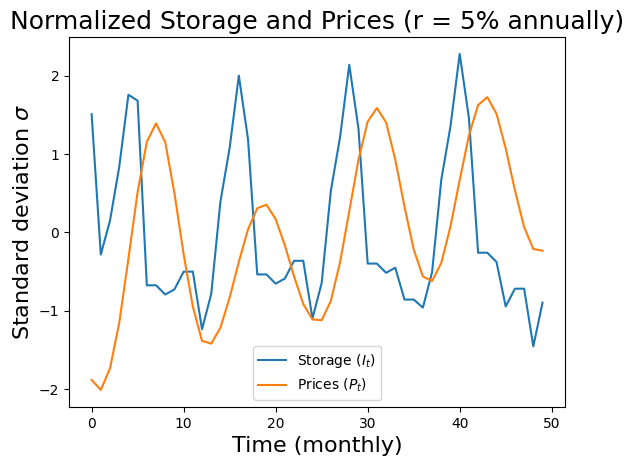

In [361]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]),label = 'Storage ($I_t$)')
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]),label = 'Prices ($P_t$)')
plt.legend()
plt.ylabel('Standard deviation $\sigma$',fontdict={'size': 16})
plt.xlabel('Time (monthly)',fontdict={'size': 16})
plt.title('Normalized Storage and Prices (r = 5% annually)',fontdict={'size': 18})
plt.savefig('Figures/storage_policy.pdf', format='pdf')
plt.show()

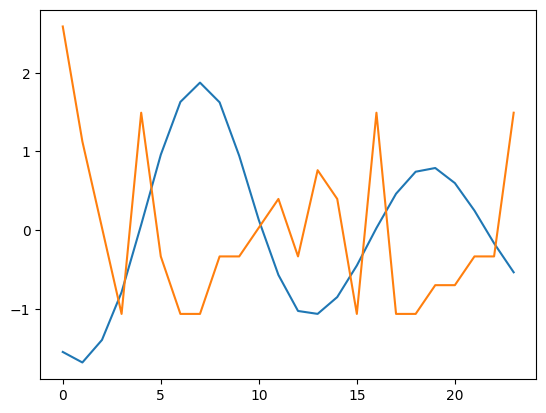

In [492]:
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]))
plt.plot((storage_price_outflow[2,:]-(np.mean(storage_price_outflow[2,:])))/np.std(storage_price_outflow[2,:]))
plt.show()

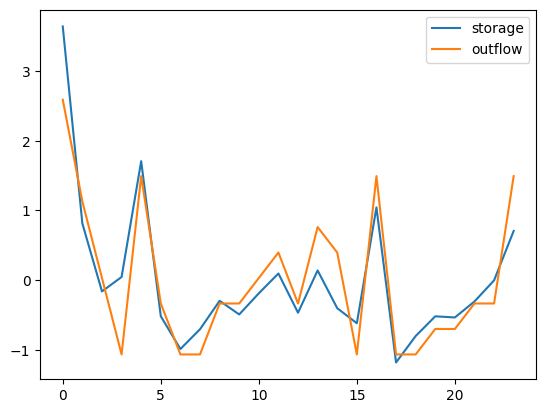

In [494]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]), label='storage')
plt.plot((storage_price_outflow[2,:]-(np.mean(storage_price_outflow[2,:])))/np.std(storage_price_outflow[2,:]), label='outflow')
plt.legend()
plt.show()

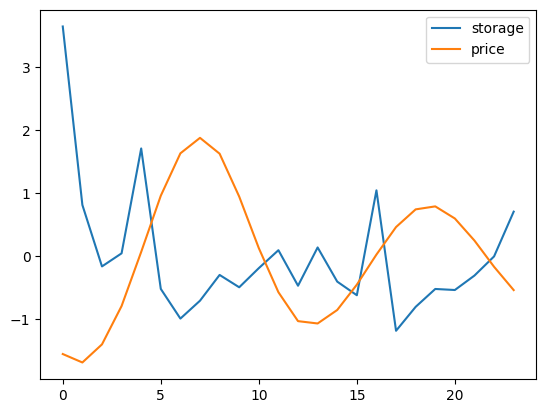

In [495]:
plt.plot((storage_price_outflow[0,:]-(np.mean(storage_price_outflow[0,:])))/np.std(storage_price_outflow[0,:]), label='storage')
plt.plot((storage_price_outflow[1,:]-(np.mean(storage_price_outflow[1,:])))/np.std(storage_price_outflow[1,:]), label='price')
plt.legend()
plt.show()

In [279]:
ts.loc[time_0-1,'storage']

2507.876580645161

In [283]:
2.592 * ts_forecast.loc[current_time - 1,'inflow']

113.34891251612903

In [284]:
next_storage(*input_next_storage, 0)

2648.104969975169

In [287]:
2.592 * model_inflow(current_time,ts_forecast.loc[current_time - 1,'inflow']) + 2507

2653.292026992198

## Simulations 

In [704]:
print(prices_sd)

0.0855231078219911


In [75]:

inflow_sd  = 66.9631265035845

def next_inflow(t,prev, shock):
    return model_inflow(t,prev) + inflow_sd * shock

In [115]:

storage_sd = 76
prices_sd  = 0.027060425667826772
inflow_sd  = 57

def next_inflow(t,prev, shock):
    return model_inflow(t,prev) + inflow_sd * shock

def next_storage(model_inflow, prev_inflow , model_evaporation, t, prev_storage, outflow, model_storage, shock_n):
    return model_storage(model_inflow, prev_inflow , model_evaporation, t, prev_storage, outflow) + storage_sd * shock_n


In [116]:
def simulating_paths(T = 10000, t0 = time_0, storage_0 = ts_forecast.loc[time_0 - 1, 'storage'], price_0 = ts_forecast.loc[time_0 - 1, 'price'], inflow_0 = ts_forecast.loc[time_0 - 1, 'inflow']):
    z_s = np.random.randn(T,S)
    z_p_hat = np.random.randn(T,S)
    z_p = correlation * z_s + np.sqrt(1-correlation**2) * z_p_hat

    storage = np.zeros((T,S+1))
    storage[:,0] = storage_0
    
    inflow = np.zeros((T,S+1))
    inflow[:,0] = inflow_0
    
#     def next_price_with_X(t,prev, prev_x, shock_m):
#         f = lambda x: coefs_log_prices[0] + coefs_log_prices[1] * sin((coefs_log_prices[2]+x)*2*pi/12)
#         mean_rever = lambda x: -0.4 * x
#         return prev*exp(f(t) + mean_rever(prev_x) + prices_sd * shock_m)
    
    price = np.zeros((T,S+1))
    price[:,0] = price_0

    outflows_grid = np.zeros((T,S))

    previous_residuals_storage = np.zeros((T,S))

    for s in range(S):
        current_time = time_0 + s

        if s == 0:
            prev_x   = np.zeros(T) + ts_forecast.loc[time_0-1 , 'X']
            prev_y_x = np.zeros(T) + ts_forecast.loc[time_0-12, 'X']

        elif s < 12:
            prev_x   = previous_residuals_storage[:,s]
            prev_y_x = np.zeros(T) + ts_forecast.loc[current_time - 12, 'X']

        else:
            prev_x   = previous_residuals_storage[:, s-1]
            prev_y_x = previous_residuals_storage[:, s-12]

        
        storage_coord, price_coord, _, _ = prepro_coord_array(storage[:,s], price[:,s])
        storage_coord, price_coord = coord_array(storage_coord, price_coord) # at this point future_price is the coord in V
                
        outflows = policy[s,:,:][storage_coord, price_coord]
        outflows_grid[:,s] = outflows

        input_next_storage = [model_inflow, ts_forecast.loc[current_time - 1,'inflow'] , model_evaporation, current_time,
                                              storage[:,s], outflows, model_storage] # Outflow changed from IV loop


        storage[:,s+1] = next_storage(*input_next_storage, z_s[:,s])
        inflow[:, s+1] = next_inflow(current_time, inflow[:,s], z_s[:,s])
        price[:,s+1]   = next_price(current_time, price[:,s], z_p[:,s])

        previous_residuals_storage[:, s] = np.log(price[:,s+1] / next_price(t,price[:,s], 0))
    
    return storage, price, outflows_grid, inflow

In [117]:
def plot_conf_int_boot(sample, quantiles = [0.05, 0.95], var_name = 'noname'):

    T = sample.shape[0]
    S = sample.shape[1]

    i_5  = int(T*quantiles[0])
    i_95 = int(T*quantiles[1])
    i_50 = int(T*0.5)

    top = np.zeros(S)
    med = np.zeros(S)
    bot = np.zeros(S)

    for t in range(S):

        sample_t = sorted(sample[:,t])

        top[t] = sample_t[i_95]
        med[t] = sample_t[i_50]
        bot[t] = sample_t[i_5]


    fig, (ax) = plt.subplots(1, 1, sharex=True)

    x = range(S)
    ax.plot(x, med , color='black', label = 'Median')
    ax.fill_between(x, bot, top, where=top >= bot, facecolor='green', interpolate=True, alpha = 0.6, label= '5% - 95% confidence interval')
    plt.legend()
    plt.title(f'Forward simulation: {T} trajectories ',fontdict={'size':'18'})
    plt.ylabel(var_name,fontdict={'size':'16'})
    plt.xlabel('Months',fontdict={'size':'16'})
    plt.grid()
    plt.tight_layout()
    

    

In [118]:
storage_sim, price_sim, outflows_sim, inflow_sim = simulating_paths()

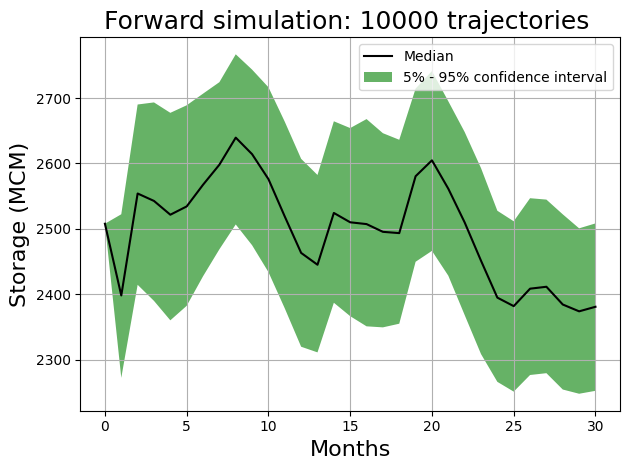

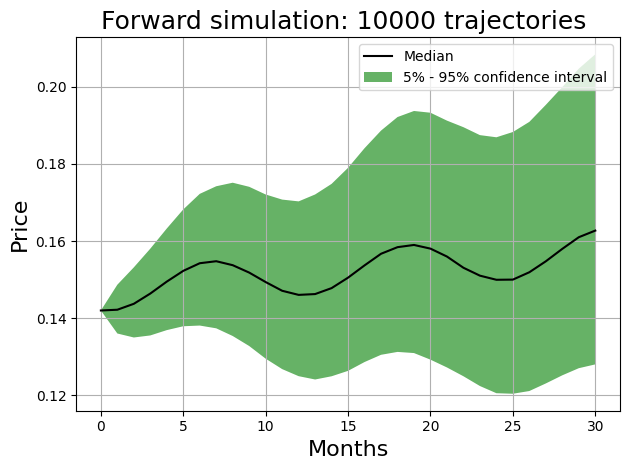

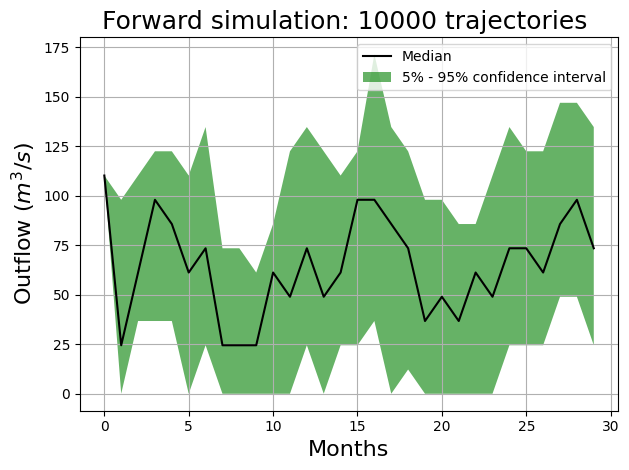

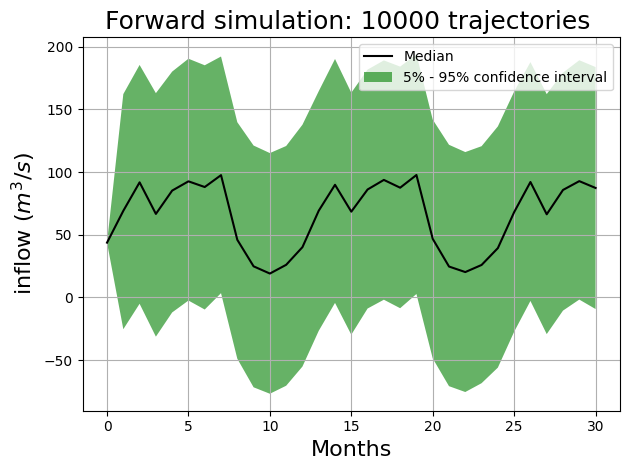

In [119]:
plot_conf_int_boot(storage_sim, var_name = 'Storage (MCM)')
plt.savefig('Figures/storage_conf_int.pdf', format='pdf')
plt.show()
plot_conf_int_boot(price_sim, var_name = 'Price' )
plt.savefig('Figures/price_conf_int.pdf', format='pdf')
plt.show()
plot_conf_int_boot(outflows_sim, var_name = 'Outflow ($m^3/s$)')
plt.savefig('Figures/outflow_conf_int.pdf', format='pdf')
plt.show()
plot_conf_int_boot(inflow_sim, var_name = 'inflow ($m^3/s$)')
plt.savefig('Figures/inflow_conf_int.pdf', format='pdf')
plt.show()

In [507]:
storage_sim, price_sim, outflows_sim = simulating_paths(t0 = time_0-10, storage_0 = ts_forecast.loc[time_0 - 10, 'storage'], price_0 = ts_forecast.loc[time_0 - 10, 'price'])

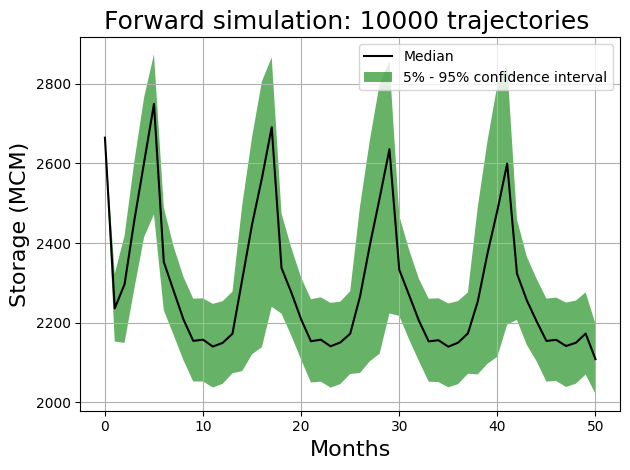

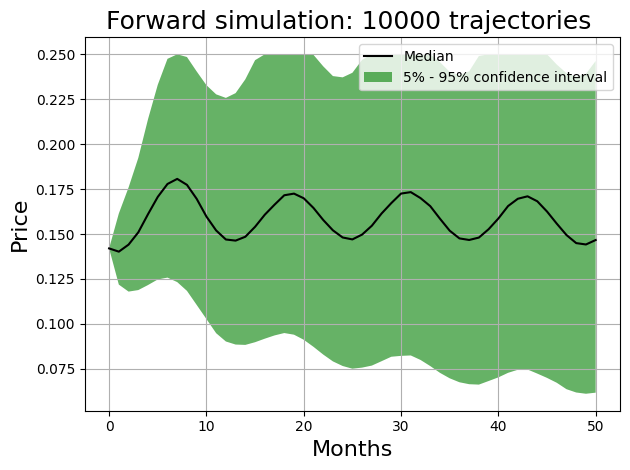

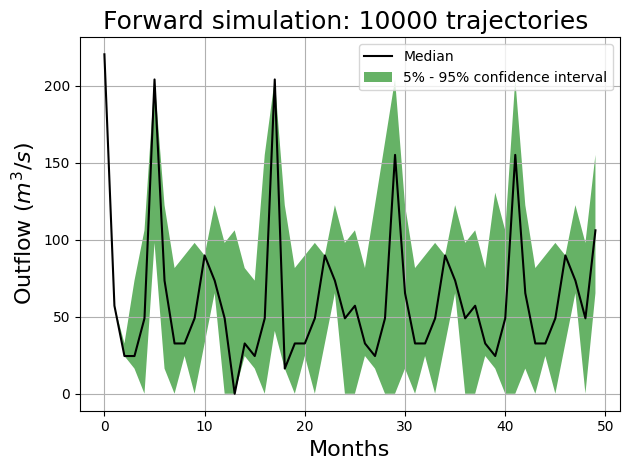

In [508]:
plot_conf_int_boot(storage_sim, var_name = 'Storage (MCM)')
plot_conf_int_boot(price_sim, var_name = 'Price' )
plot_conf_int_boot(outflows_sim, var_name = 'Outflow ($m^3/s$)')

In [ ]:
storage_sim, price_sim, outflows_sim = simulating_paths()

In [ ]:
plot_conf_int_boot(storage_sim, var_name = 'Storage (MCM)')
plot_conf_int_boot(price_sim, var_name = 'Price' )
plot_conf_int_boot(outflows_sim, var_name = 'Outflow ($m^3/s$)')